## Dependencies

In [1]:
!pip install -qq transformers accelerate

In [2]:
import re
import random

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from transformers.data.processors.utils import InputFeatures

In [4]:
## Setting Device

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [5]:
## Seeding RNGs for reproducible training

SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
print(torch.__version__)
print(transformers.__version__)

2.5.1+cu121
4.47.1


## Loading, Analyzing and Preprocessing  Dataset

In [7]:
!gdown --id 1f1i2emJX6bNBxOb_j7crKSAi-LCgkWER -O dataset.tcv

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1f1i2emJX6bNBxOb_j7crKSAi-LCgkWER
To: /content/dataset.tcv
100% 54.4M/54.4M [00:00<00:00, 69.7MB/s]


In [9]:
df = pd.read_csv("/content/dataset.tcv", sep='\t')
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   99999 non-null  object
 1   text    99999 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [10]:
DATA_COLUMN = "text"
LABEL_COLUMN = "label"

In [11]:
df.head(n=10)

,label,text
0,Positive,ممتاز نوعا ما . النظافة والموقع والتجهيز والشا...
1,Positive,أحد أسباب نجاح الإمارات أن كل شخص في هذه الدول...
2,Positive,هادفة .. وقوية. تنقلك من صخب شوارع القاهرة الى...
3,Positive,خلصنا .. مبدئيا اللي مستني ابهار زي الفيل الاز...
4,Positive,ياسات جلوريا جزء لا يتجزأ من دبي . فندق متكامل...
5,Positive,أسلوب الكاتب رائع جدا و عميق جدا، قرأته عدة مر...
6,Positive,استثنائي. الهدوء في الجناح مع مسبح. عدم وجود ع...
7,Positive,الكتاب هو السيرة الذاتية للحداثة في المملكة بل...
8,Positive,من أجمل ما قرأت.. رواية تستحق القراءة فعلا..
9,Positive,بشكل عام جيده .. . التجاوب جيد جدا من قبل موظف...


In [12]:
df.tail(n=10)

,label,text
99989,Negative,بسم الله الرحمن الرحيم. وأنه كان رجال من الإنس...
99990,Negative,ضعيف جدا. لا شي نهائيا. استقبال السوداني جدا ج...
99991,Negative,الفندق مخيب ودون المستوى . . تأخير عند الاستقب...
99992,Negative,لم اجد فيها شيء مميز لا اعتقد انها تستحق ان تك...
99993,Negative,تقييم منصف للفندق الرديء الجودة الغالي السعر ....
99994,Negative,معرفش ليه كنت عاوزة أكملها وهي مش عاجباني من ا...
99995,Negative,لا يستحق ان يكون في بوكنق لانه سيئ . لا شي. لا...
99996,Negative,كتاب ضعيف جدا ولم استمتع به. فى كل قصه سرد لحا...
99997,Negative,مملة جدا. محمد حسن علوان فنان بالكلمات، والوصف...
99998,Negative,لن ارجع إليه مرة اخرى . قربه من البحر. المكان ...


In [13]:
df[LABEL_COLUMN].value_counts()

,count
label,
Positive,33333
Mixed,33333
Negative,33333


In [14]:
# Splitting the dataset again into train/test datasets
train_main, test_main = train_test_split(df, test_size=0.3, shuffle=True, random_state=SEED, stratify=df[LABEL_COLUMN])
label_list_main = list(df[LABEL_COLUMN].unique())

print("Training length: ", len(train_main))
print(train_main[LABEL_COLUMN].value_counts(), '\n')

print("Testing length: ", len(test_main))
print(test_main[LABEL_COLUMN].value_counts())

Training length:  69999
label
Positive    23333
Mixed       23333
Negative    23333
Name: count, dtype: int64 

Testing length:  30000
label
Positive    10000
Negative    10000
Mixed       10000
Name: count, dtype: int64


In [16]:
label_list_df_main = list(df[LABEL_COLUMN].unique())
print(label_list_df_main)

['Positive', 'Mixed', 'Negative']


## Clean and Prepare Dataset for input

In [25]:
class CustomDataset:

    def __init__(self, name: str, train: pd.DataFrame, test: pd.DataFrame, label_list: list[str]):
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

In [26]:
data_main = CustomDataset("Dataset", train_main, test_main, label_list_df_main)

In [27]:
print(data_main.name)
print(data_main.label_list)
print("Number of Labels:", len(data_main.label_list))

Dataset
['Positive', 'Mixed', 'Negative']
Number of Labels: 3


In [28]:
def preprocess(text):
  # Remove HTML
  html_remover= re.compile(r'\?&#$%@\*^')
  text = re.sub(html_remover, '', text)

  return text

In [29]:
data_main.train[DATA_COLUMN] = data_main.train[DATA_COLUMN].apply(preprocess)
data_main.test[DATA_COLUMN] = data_main.test[DATA_COLUMN].apply(preprocess)

In [30]:
# Make sure cleaning didn't mess up any sample
nan_in_col = data_main.train[data_main.train[DATA_COLUMN].isnull()]
nan_in_col

,label,text


In [31]:
data_main.train.head(n=10)

,label,text
28509,Positive,خواطر رائعة وخلاصة تجارب وسلوكيات من اليابان ....
21094,Positive,عبد بنى قراره المصيري في حياته ومستقبله ليدعم ...
40933,Mixed,أول غلطة وقعت فيها ، إنى افتكرت إنى باقرا رواي...
2726,Positive,لا يحتاج . كل شى. لاشى
33091,Positive,بيقول : نظريه المؤامره لذيذه وتروق للجميع لانه...
43525,Mixed,حسن. فندق جميل.
80542,Negative,لا تقرب من هالفندق . الفطور مقبول وموقع الفندق...
9373,Positive,جيد. قرب الفندق من التوسعه الجديدة ومستوى النظ...
4690,Positive,يستاهل التجربة . قربه من الكورنيش وطريقة معامل...
6027,Positive,أعجبتني فكرة الكتاب للغاية و أدهشني ذلك الدويت...


## Tokenizing the Dataset and helper functions

In [32]:
model_name = "aubmindlab/bert-large-arabertv02" # chosen model

In [33]:
# we need to check the tokenized sentences' length to decide on the maximum sentence length value
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [34]:
tokenizer.tokenize("ممتاز نوعا ما . النظافة والموقع والتجهيز والشاطيء. المطعم")

['ممتاز',
 'نوعا',
 'ما',
 '.',
 'النظافة',
 'والموقع',
 'والتجهيز',
 'والش',
 '##اطي',
 '##ء',
 '.',
 'المطعم']

In [35]:
tokenizer.vocab_size

64000

In [36]:
tokenizer.get_vocab()

{'نعيم': 17597,
 'اتحادية': 42259,
 'يشاع': 41095,
 'والبرنامج': 31446,
 'واللاعب': 11972,
 'طباعة': 22900,
 '##ريدات': 53754,
 'صريحا': 32656,
 'وطريقة': 16364,
 '##23': 16954,
 'المكرمين': 38016,
 'والامان': 46412,
 'والقذف': 44163,
 'وأنصار': 25670,
 'قاع': 22042,
 '##كاك': 13677,
 'عيس': 47620,
 'التعثر': 38279,
 'والوقت': 27753,
 '[UNUSED_1685]': 61685,
 'القديسين': 33983,
 'حقوقهم': 12441,
 'خطابات': 20375,
 'وعرض': 5609,
 'اوت': 24192,
 'الدير': 23638,
 'سرية': 8807,
 'دمى': 58689,
 'شرب': 12783,
 '##فيش': 27006,
 'جولة': 5927,
 'الأقل': 3659,
 'الأغلى': 49826,
 'الآدم': 28197,
 '[UNUSED_3486]': 63486,
 'افتتح': 8669,
 'الأسوأ': 24518,
 'لتكرار': 43608,
 'قبة': 22753,
 'وشراء': 20618,
 'للرب': 45816,
 'الجامعيين': 30372,
 'غيرهم': 13434,
 '[UNUSED_3932]': 63932,
 'المجهزة': 44771,
 'ارهابية': 18298,
 'الاشتباكات': 10138,
 'المثالي': 24929,
 '##أ': 230,
 'طورت': 34971,
 '[UNUSED_530]': 60530,
 '##غوبة': 42699,
 'أبسط': 22680,
 'عمن': 23924,
 '[UNUSED_3718]': 63718,
 'حفرة': 31045

Token indices sequence length is longer than the specified maximum sequence length for this model (538 > 512). Running this sequence through the model will result in indexing errors


Training Sentence Lengths: 


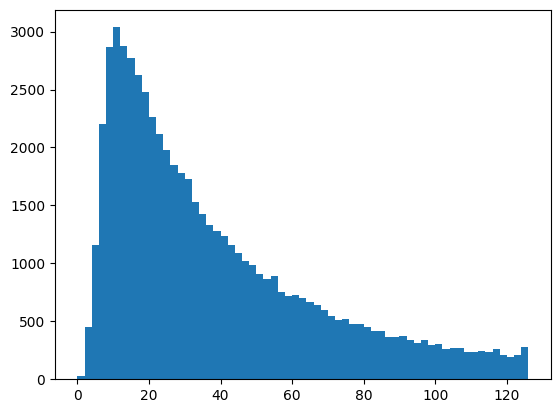

Testing Sentence Lengths: 


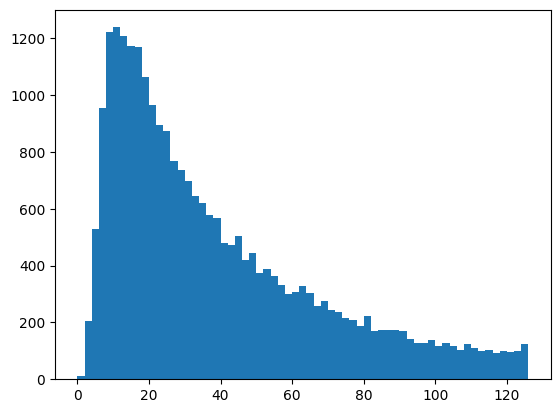

In [37]:
print("Training Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_main.train[DATA_COLUMN].to_list() ], bins=range(0,128,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tokenizer.tokenize(sentence)) for sentence in data_main.test[DATA_COLUMN].to_list() ], bins=range(0,128,2))
plt.show()

# Most of the samples in the dataset are less than 512 tokens

In [38]:
max_len = 512

# Filter out sentences longer than max_len (512 tokens)
train_filtered = data_main.train[data_main.train[DATA_COLUMN].apply(lambda x: len(tokenizer.tokenize(x)) <= max_len)]
test_filtered = data_main.test[data_main.test[DATA_COLUMN].apply(lambda x: len(tokenizer.tokenize(x)) <= max_len)]

# Print how many sentences were removed
print("Removed training sequences: ", len(data_main.train) - len(train_filtered))
print("Removed testing sequences: ", len(data_main.test) - len(test_filtered))

# Update the dataset to use only sentences under max_len
data_main.train = train_filtered
data_main.test = test_filtered


Removed training sequences:  971
Removed testing sequences:  404


In [39]:
max_len = 128

print("Truncated training sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.train[DATA_COLUMN].to_list()]))
print("Truncated testing sequences: ", sum([len(tokenizer.tokenize(sentence)) > max_len for sentence in data_main.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  8706
Truncated testing sequences:  3725


In [40]:
# Creating a PyTorch dataset object to load the data into the Trainer API

class ClassificationDataset(Dataset):

    def __init__(self, text: list[str], target: list[str], model_name: str, max_len: int, label_map: dict[str, int]):
      super().__init__()

      self.text = text
      self.target = target
      self.tokenizer_name = model_name
      self.tokenizer = AutoTokenizer.from_pretrained(model_name)
      self.max_len = max_len
      self.label_map = label_map

    def __len__(self):
      return len(self.text)

    def __getitem__(self, item):
      text = str(self.text[item])
      text = " ".join(text.split())

      inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
      )

      # return input_ids, attention_mask, token_type_ids, label
      return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [41]:
label_map = { v:index for index, v in enumerate(data_main.label_list) }
print(label_map)

{'Positive': 0, 'Mixed': 1, 'Negative': 2}


In [42]:
# Create train/test Pytorch datasets

train_dataset = ClassificationDataset(
    data_main.train[DATA_COLUMN].to_list(),
    data_main.train[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

test_dataset = ClassificationDataset(
    data_main.test[DATA_COLUMN].to_list(),
    data_main.test[LABEL_COLUMN].to_list(),
    model_name,
    max_len,
    label_map
  )

print(train_dataset[0])

InputFeatures(input_ids=[2, 50901, 9367, 15684, 688, 7936, 20885, 449, 306, 5141, 20, 20, 33814, 5455, 305, 13397, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], attention_mask=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], token_type_ids=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [43]:
input_ids = train_dataset[0].input_ids

tokenizer.decode(input_ids)

'[CLS] خواطر رائعة وخلاصة تجارب وسلوكيات من اليابان.. طبقت بعضها في حياتي [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [44]:
# returns a pretrained model for finetuning in the trainer API
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=len(label_map))
    return model

## Begin Regular Training

In [45]:
import torch
torch.cuda.empty_cache()


In [46]:
# some metrics we would like to see
# p should be of type EvalPrediction

def compute_metrics(p):
  preds = np.argmax(p.predictions, axis=1)
  assert len(preds) == len(p.label_ids)

  print(classification_report(p.label_ids, preds))
  print()
  print(confusion_matrix(p.label_ids, preds))

  macro_f1 = f1_score(p.label_ids, preds, average='macro')
  macro_precision = precision_score(p.label_ids, preds, average='macro')
  macro_recall = recall_score(p.label_ids, preds, average='macro')
  accuracy = accuracy_score(p.label_ids, preds)

  return {
      'macro_f1' : macro_f1,
      'macro_precision': macro_precision,
      'macro_recall': macro_recall,
      'accuracy': accuracy
  }

In [47]:
# setting training parameters
training_args = TrainingArguments(
  output_dir= "train",
  adam_epsilon = 1e-8,
  learning_rate = 2e-5,
  report_to="tensorboard",
  fp16 = True,
  per_device_train_batch_size = 32,
  per_device_eval_batch_size = 32,
  gradient_accumulation_steps = 8,
  num_train_epochs = 2,
  warmup_ratio = 0,
  do_eval = True,
  evaluation_strategy = 'epoch',
  save_strategy = 'epoch',
  load_best_model_at_end = True,
  metric_for_best_model = 'macro_f1',
  greater_is_better = True
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [48]:
# creating the trainer object
trainer = Trainer(
    model = model_init(),
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/1.48G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-large-arabertv02 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [49]:
# start the training
trainer.train()

Epoch,Training Loss,Validation Loss,Macro F1,Macro Precision,Macro Recall,Accuracy
0,No log,0.703532,0.678846,0.679311,0.678695,0.678639
1,7.315400,0.904568,0.513198,0.545023,0.527508,0.527335


              precision    recall  f1-score   support

           0       0.72      0.74      0.73      9853
           1       0.57      0.57      0.57      9875
           2       0.75      0.73      0.74      9868

    accuracy                           0.68     29596
   macro avg       0.68      0.68      0.68     29596
weighted avg       0.68      0.68      0.68     29596


[[7289 2083  481]
 [2379 5636 1860]
 [ 521 2187 7160]]
              precision    recall  f1-score   support

           0       0.48      0.77      0.59      9853
           1       0.53      0.32      0.40      9875
           2       0.63      0.49      0.55      9868

    accuracy                           0.53     29596
   macro avg       0.55      0.53      0.51     29596
weighted avg       0.55      0.53      0.51     29596


[[7605 1269  979]
 [4857 3134 1884]
 [3467 1533 4868]]


TrainOutput(global_step=538, training_loss=7.366868710429252, metrics={'train_runtime': 2744.5726, 'train_samples_per_second': 50.301, 'train_steps_per_second': 0.196, 'total_flos': 3.211819102597939e+16, 'train_loss': 7.366868710429252, 'epoch': 1.9972196478220574})

## Finetuned Model Evaluation

In [ ]:
trainer.evaluate()

              precision    recall  f1-score   support

           0       0.70      0.82      0.76      9853
           1       0.64      0.55      0.59      9875
           2       0.78      0.75      0.76      9868

    accuracy                           0.71     29596
   macro avg       0.71      0.71      0.70     29596
weighted avg       0.71      0.71      0.70     29596


[[8098 1394  361]
 [2694 5446 1735]
 [ 771 1721 7376]]


{'eval_loss': 0.653657078742981,
 'eval_macro_f1': 0.7032763565780064,
 'eval_macro_precision': 0.7050647122347588,
 'eval_macro_recall': 0.7069472966224132,
 'eval_accuracy': 0.706852277334775,
 'eval_runtime': 154.8736,
 'eval_samples_per_second': 191.098,
 'eval_steps_per_second': 5.973,
 'epoch': 1.995366079703429}

## Saving the finetuned BERT model and tokenizer for model inference

In [ ]:
print(label_map)

inv_label_map = { v:k for k, v in label_map.items()}

print(inv_label_map)

In [ ]:
trainer.model.config.label2id = label_map
trainer.model.config.id2label = inv_label_map

SAVE_PATH = 'model'

In [ ]:
trainer.save_model(SAVE_PATH)
train_dataset.tokenizer.save_pretrained(SAVE_PATH)

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json',
 'model/tokenizer.json')

## Classification Report and Confusion Matrix

In [ ]:
pipe = pipeline(task="text-classification", model=SAVE_PATH, device=device, max_length=512, truncation=True, padding='max_length')

In [ ]:
tests = data_main.test[LABEL_COLUMN].to_list()
results = pipe(data_main.test[DATA_COLUMN].to_list())

preds = [res['label'] for res in results]

print("Test labels ", tests[:10])
print("Predicted Testing Dataset labels: ", preds[:10])

In [ ]:
print(classification_report(tests, preds))

In [ ]:
list(label_map)

In [ ]:
cm = confusion_matrix(y_true=tests, y_pred=preds, labels=list(label_map))
cmd = ConfusionMatrixDisplay(cm, display_labels=list(label_map))
cmd.plot(values_format='')

## Model Inference

In [ ]:
texts = ["The Movie wasn't as good as i expected", 'What a cast of actors']

results = pipe(texts)

for idx, result in enumerate(results):
  print(texts[idx], result)